# Hackathon 2024

Here we've defined the columns we want to extract. We decided on these columns through some analysis on the data itself, but mostly from domain knowlegde as we didn't see much statistical hints to what columns would be useful.

In [1]:
DATA = "HackathonData2024.csv"
FEATURES = ['Pressure Gradient (psi/ft) new', 'Avg Open Pressure', 'Avg Close Pressure', "TVD", 'Soak Time', 
             "PARENT_3000_WELL_COUNT", 'PARENT_1050_WELL_COUNT', 'PARENT_3000_AVG_TVD_DIST', 'PARENT_OUT_ZONE_MIN_HYPOT', 'PARENT_IN_ZONE_MIN_HYPOT', 'PARENT_3000_MEDIAN_WELL_AGE']
#             'PARENT_3000_AVG_WELL_AGE', 'PARENT_1050_AVG_WELL_AGE', 'CODEV_3000_AVG_WELL_AGE']

# FEATURES = ['Pressure Gradient (psi/ft) new', 'Avg Open Pressure', 'Avg Close Pressure', "TVD", 'Soak Time', 
#              "PARENT_3000_WELL_COUNT", 'PARENT_1050_WELL_COUNT', 'PARENT_3000_AVG_TVD_DIST', 'PARENT_OUT_ZONE_MIN_HYPOT', 'PARENT_IN_ZONE_MIN_HYPOT']
#             'PARENT_3000_AVG_WELL_AGE', 'PARENT_1050_AVG_WELL_AGE', 'CODEV_3000_AVG_WELL_AGE']


#  FEATURES = ['Pressure Gradient (psi/ft) new', 'Soak Time', 'Avg Open Pressure', 'Avg Close Pressure', 'TVD',
#              'PARENT_OUT_ZONE_MIN_HYPOT', 'CODEV_IN_ZONE_MIN_HYPOT', 'PARENT_1050_MEDIAN_WELL_AGE', 'CODEV_OUT_ZONE_MIN_HYPOT', 'PARENT_3000_WELL_COUNT']

TARGET = "Avg Pump Difference"

import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
pd.read_csv(DATA).columns

Index(['Well ID', 'Avg Pump Difference', 'Area', 'Lateral Length',
       'Fluid System', 'TVD', 'Development Strategy', 'DELAYED', 'BOUND_CODE',
       'CODEV_POSITION', 'CODEV_FORMATION_POSITION',
       'PARENT_CODEV_1050_WELL_COUNT', 'PARENT_IN_ZONE_MIN_HYPOT',
       'PARENT_OUT_ZONE_MIN_HYPOT', 'PARENT_IN_ZONE_MIN_MAP_DIST',
       'PARENT_OUT_ZONE_MIN_MAP_DIST', 'PARENT_1050_AVG_WELL_AGE',
       'PARENT_1050_MEDIAN_WELL_AGE', 'PARENT_1050_WELL_COUNT',
       'PARENT_3000_AVG_HYPOT_DIST', 'PARENT_3000_AVG_MAP_DIST',
       'PARENT_3000_AVG_TVD_DIST', 'PARENT_3000_AVG_WELL_AGE',
       'PARENT_3000_MEDIAN_WELL_AGE', 'PARENT_3000_WELL_COUNT',
       'CODEV_IN_ZONE_MIN_HYPOT', 'CODEV_OUT_ZONE_MIN_HYPOT',
       'CODEV_IN_ZONE_MIN_MAP_DIST', 'CODEV_1050_WELL_COUNT',
       'CODEV_3000_AVG_HYPOT_DIST', 'CODEV_3000_AVG_MAP_DIST',
       'CODEV_3000_AVG_TVD_DIST', 'CODEV_3000_AVG_WELL_AGE',
       'CODEV_3000_MEDIAN_WELL_AGE', 'CODEV_3000_WELL_COUNT',
       'Pressure Gradient (psi/ft)

In [3]:
import seaborn as sns
sns.set_style("whitegrid")

## Data Cleaning and Preparation

We remove the solution rows; that is, the rows that do not have a value in the target column. Then, we examine the distribution of our chosen features. By examining correlated features in our correlation matrix, determining high information features through a measure of mutual information, and domain knowledge, we select the following features to use in our model:

- `Pressure Gradient (psi/ft) new` the pressure over depth would make sense to have the highest impact on the difference in flow rate
- `Avg Open Pressure`, `Avg Close Pressure` had good mutual information scores and are related to the pressure gradient
- `TVD` how far the fluid has to travel would cause a difference in flow rate
- `Soak Time` surrounding factors of the well would cause a difference in how much fluid escapes into the well
- `PARENT_1050_WELL_COUNT`, `PARENT_3000_WELL_COUNT` the number of wells in the area is another environmental factor that affects fluid escape rate
- `PARENT_3000_AVG_TVD_DIST`, `PARENT_OUT_ZONE_MIN_HYPOT`, `PARENT_IN_ZONE_MIN_HYPOT` characteristics of the parent well that affect how far the fluid has to travel
- `PARENT_3000_MEDIAN_WELL_AGE` we chose median over average as we found it to be a slightly better signal and robust to outliers

In [4]:
df = pd.read_csv(DATA, index_col='Well ID')
df = df[FEATURES + [TARGET]]
df.dropna(subset=[TARGET], inplace=True)

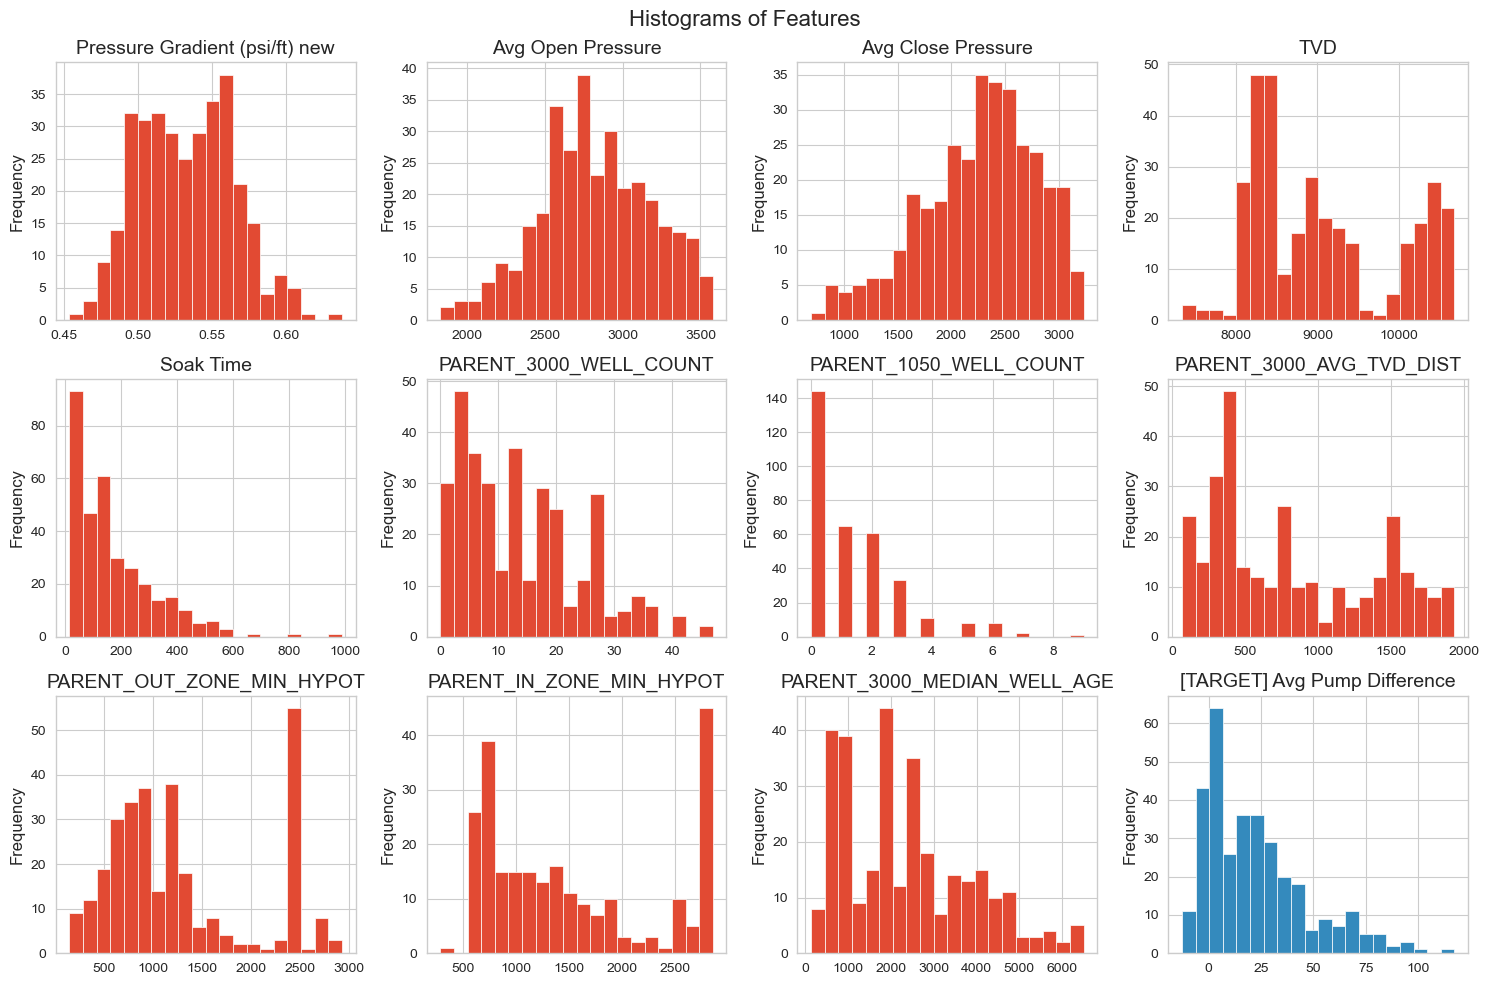

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, feature in enumerate(FEATURES):
    ax = axes[i // 4, i % 4]
    df[feature].plot.hist(ax=ax, bins=20)
    ax.set_title(feature, fontsize=14)

fig.suptitle("Histograms of Features", fontsize=16)
ax = axes[2, 3]
df[TARGET].plot.hist(ax=ax, bins=20, color=plt.rcParams["axes.prop_cycle"].by_key()["color"][1])
ax.set_title(f"[TARGET] {TARGET}", fontsize=14)
plt.tight_layout()
plt.show()


We split our data into training and testing sets, and then we scale the data using a StandardScaler (which does not change the distribution of the data). We previously tried a QuantileScaler as well, which changes the distribution to approximately Gaussian, but we did not see good results through this method. We split our dataset first to avoid data leakage.

In [187]:
from sklearn.model_selection import train_test_split

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1997)

In [188]:
from sklearn import preprocessing
import numpy as np
scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train)

def x_scale(df):
    return pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

X_train = x_scale(X_train)
X_test = x_scale(X_test)

In [189]:
# fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# for i, feature in enumerate(FEATURES):
#     ax = axes[i // 5, i % 5]
#     X_train[feature].plot.hist(ax=ax, bins=20)
#     ax.set_title(FEATURES[i])
# plt.tight_layout()
# plt.show()

This is the distribution of the target column, which we plot to see if there is any imbalance or if we need to scale our target column as well.

(array([ 7., 34., 49., 18., 28., 28., 26., 14., 15.,  6.,  8.,  7., 10.,
         4.,  5.,  2.,  3.,  1.,  0.,  1.]),
 array([-12.43  ,  -5.9455,   0.539 ,   7.0235,  13.508 ,  19.9925,
         26.477 ,  32.9615,  39.446 ,  45.9305,  52.415 ,  58.8995,
         65.384 ,  71.8685,  78.353 ,  84.8375,  91.322 ,  97.8065,
        104.291 , 110.7755, 117.26  ]),
 <BarContainer object of 20 artists>)

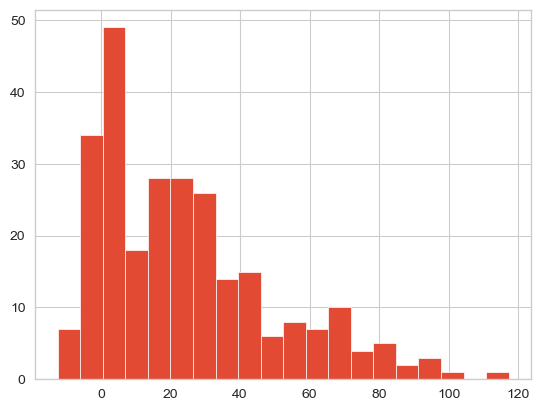

In [190]:
plt.hist(y_train, bins=20)

Then we impute our data, as we had lots of missing values which shrunk our data tremendously. We settled on a KNN imputer, which imputes the missing values based on the values of the nearest neighbors.

In [191]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=FEATURES)
X_test = pd.DataFrame(imputer.transform(X_test), columns=FEATURES)

## Model creation

We use a simple linear regression model to gain insights from our data. We tried many other models, such as

- Various complex regressors, such as RandomForest regressors and XGBoost
- Splitting our data by fluid type and training a separate linear (and complex) regressor for each fluid type

But none were quite as robust as a simple linear regression model.

In [192]:
import statsmodels.api as sm

ols = sm.OLS(list(y_train), X_train)
model = ols.fit()

We define functions that can be used to run inference on our model as well as sample from our model's distribution for use later.

In [193]:
import numpy as np

def predict(X, err=0.05):
    
    res = model.get_prediction(X)
    conf_int = res.conf_int(alpha=err)
    return res.predicted_mean, conf_int

def sample(X, n=10):
    # sample the model to get a distribution of predictions

    y_pred, conf_int = predict(X, err=0.05)
    samples = np.random.normal(loc=y_pred, scale=conf_int[:, 1] - y_pred, size=(n, len(X)))
    return samples

## Evaluating the model

We can plot the confidence intervals of our model's predictions, along with the actual values, to see how well our model performs. We can also plot the goodness of fit, which measures how good our model's *uncertainty* is, to determine if it is robust.

Root Mean Squared Error: 16.04724283780617


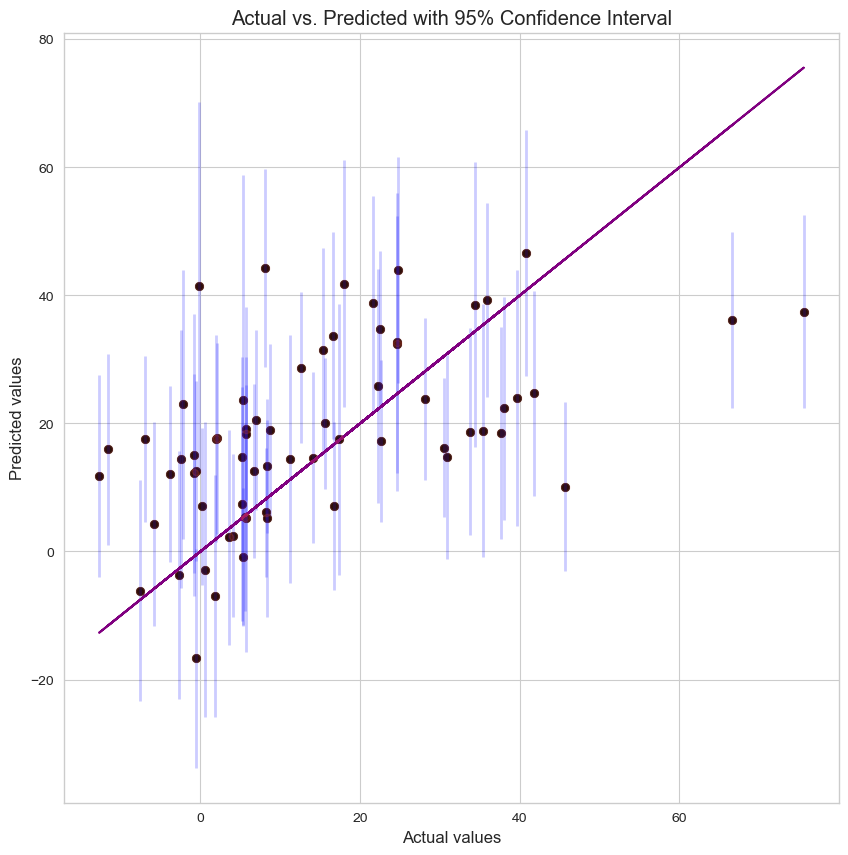

FEATURES: Index(['Pressure Gradient (psi/ft) new', 'Avg Open Pressure',
       'Avg Close Pressure', 'TVD', 'Soak Time', 'PARENT_3000_WELL_COUNT',
       'PARENT_1050_WELL_COUNT', 'PARENT_3000_AVG_TVD_DIST',
       'PARENT_OUT_ZONE_MIN_HYPOT', 'PARENT_IN_ZONE_MIN_HYPOT',
       'PARENT_3000_MEDIAN_WELL_AGE'],
      dtype='object')


In [197]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import math

# compile test data
y_pred, conf_ints = predict(X_test, err=0.05)
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", math.sqrt(mse))

plt.figure(figsize=(10,10))

plt.scatter(y_test, y_pred, label="Values", color="black", edgecolors='black')
plt.errorbar(y_test, y_pred, yerr=conf_ints[:, 1] - conf_ints[:, 0], fmt='o', alpha=0.2, ecolor='blue', elinewidth=2)
plt.plot(y_test, y_test, color='purple')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title("Actual vs. Predicted with 95% Confidence Interval")
plt.xlim(-20, 80)
plt.ylim(-20, 80)
# plt.xlim(-2, 2.5)
# plt.ylim(-2, 2.5)
plt.show()

print("FEATURES:", X.columns)

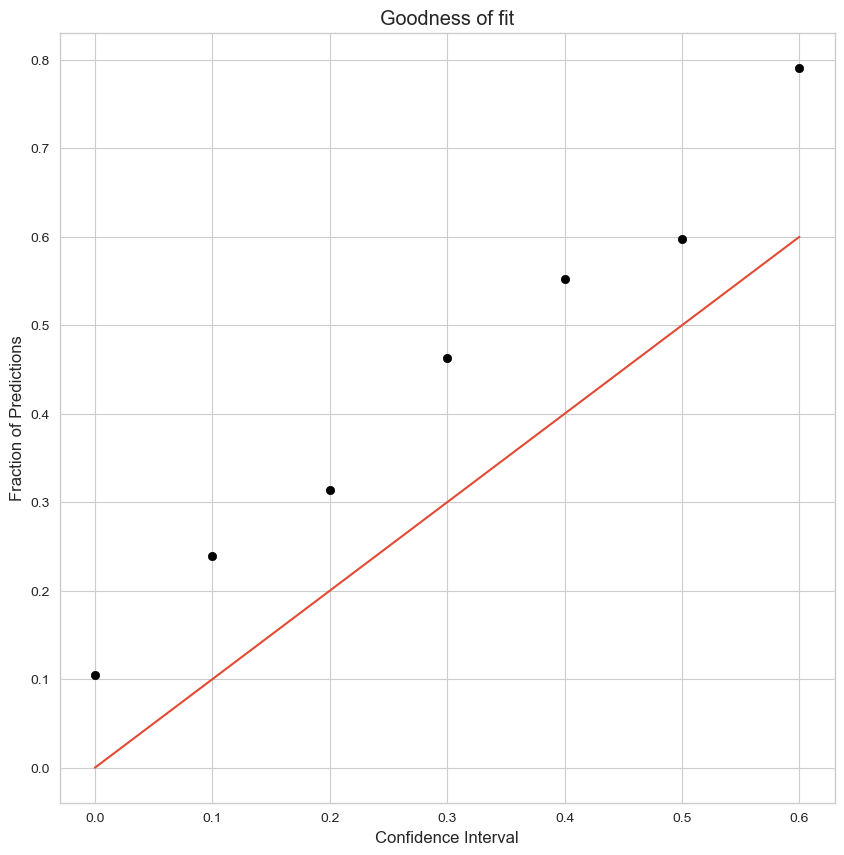

In [195]:
samples = sample(X_test, n=100)
bins = [20, 40, 60, 80, 90, 95, 100]
fraction_in = np.zeros(len(bins))
for i in range(len(bins)):
    lower = np.percentile(samples, (100 - bins[i]) / 2, axis=0)
    upper = np.percentile(samples, 100 - (100 - bins[i]) / 2, axis=0)
    fraction_in[i] = np.mean((y_test >= lower) & (y_test <= upper))

plt.figure(figsize=(10,10))
plt.scatter(np.arange(len(bins)) / 10, fraction_in, label="Values", color="black", edgecolors='black')
plt.plot(np.arange(len(bins)) / 10, np.arange(len(bins)) / 10)
plt.xlabel('Confidence Interval')
plt.ylabel('Fraction of Predictions')
plt.title("Goodness of fit")
plt.show()

## Creating our solution

In [196]:
# full_df = pd.read_csv(DATA, index_col='Well ID')
# train_df = full_df[full_df[TARGET].isna() == False]

# # get our train set, scale and impute
# x_train = train_df[FEATURES]
# y_train = train_df[TARGET]
# scaler = preprocessing.StandardScaler()
# imputer = KNNImputer(n_neighbors=5)
# x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=FEATURES)
# x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=FEATURES)

# # train our full model
# ols = sm.OLS(list(y_train), x_train)
# model = ols.fit()

# # get the final solution
# test_df = full_df[full_df[TARGET].isna() == True]
# well_ids = test_df.index

# X_sol = test_df[FEATURES]
# X_sol = pd.DataFrame(scaler.transform(X_sol), columns=FEATURES)
# X_sol = pd.DataFrame(imputer.transform(X_sol), columns=FEATURES)
# y_sol, _ = predict(X_sol)

# samples = sample(X_sol, n=100)

# with open('sample_solutions.csv', 'a') as f:
#     for i in range(len(y_sol)):
#         f.write(f"{well_ids[i]},")
#         f.write(f"{y_sol[i]},")
#         l = ",".join([str(x) for x in samples[:, i]])
#         f.write(l)
#         f.write("\n")